# Прогноз отказа мотор на основе показаний датчиков.

Описание данных :
- id -- идентификатор мотора
- cycle -- цикл работы
- p00-p20 -- показания датчиков считываемые в процессе работы
- s0, s1 -- настройки изменяемые в конце каждого цикла

**Необходимо предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике.**
Считаем, что максимальный цикл мотора в данных -- это последний цикл перед поломкой.
Нужно предложить варианты использования полученной модели на практике.

**Доп. задание**: предложить альтернативную постановку задачи прогноза отказа моторов.

## 1) Постановка задачи

По имеющимся данным будем решать задачу регрессии: **таргет** - максимальный цикл работы мотора. 

Для каждого мотора определен свой ожидаемый срок эксплуатации. Независимо от внешних факторов в процессе работы детали и связующие любого устройства претерпевают износ. 

При этом есть вероятность, что режим работы и эксплуатации мотора влияют на его долговечность. Такие явления как перегрев, повышенное давление, недостаток смазочных средств или кислородное голодание двигателя могут существенно снизить среднее время жизни одного из элементов или всего устройства. Такие обстоятельства на производстве ведут к потере времени, простою, нарушению производственной цепи и к соответсвующим экономическим последствиям на предприятии.

Таким, образом есть потребность в прогнозировании ожидаемого дня отказа мотора для его своевременной замены или ремонта комплектующих.

### Импорт библиотек

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score

## 2) Обработка данных

Посмотрим на сырые данные

In [2]:
data_raw = pd.read_csv('data/data.csv')
data_raw.head(3)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003


Датасет представляет собой аналог временного ряда отсортированный по индентификатору мотора.

Некоторые признаки содержат константы, удалим такие столбцы:

In [3]:
# Delete const
for column in data_raw.columns:
    # If only one unique in column -> delete column
    if len(data_raw[column].unique())==1:
        data_raw.drop(columns=column, inplace=True)
data_raw.shape

(16138, 19)

6 столбцов удалено.

Добавим в датасет признаки дифференцирования, характеризующие скорость изменения показаний датчиков: 
 - **разность между рядом и его сдвинутой копией**  для каждого признака **кроме id и cycle**

Получаем еще 17 признаков в нашу выборку

In [4]:
for column in data_raw.columns:
    if column not in ['id','cycle']:
        data_raw['dif_'+column] = np.insert(np.diff(data_raw.p03),0,0)
data_raw.head(3)

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,...,dif_p12,dif_p13,dif_p14,dif_p15,dif_p17,dif_p18,dif_p19,dif_p20,dif_s1,dif_s2
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,...,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,...,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14


1) Теперь сгенерируем стандартные статистические признаки для задачи поиска аномалий. Будем использовать такие характеристики ряда как :
- максимум, минимум, среднее, медиана, стандартное отклонение, квантиль, взвешенный диапазон
- количество случаев выхода признака за доверительный интервал порядка альфа

2) Странно было бы использовать признаки полученные за весь срок эксплуатации мотора. Это могло бы привести к переобучению. 
Действительно, если средний срок эксплуатации мотора = 200 циклов, то , обучив модель на выборке по всем циклам, модель будет давать плохие прогнозы на данных, когда мотор еще работает и текущий цикл = 100.

А предсказывать срок службы уже сломанного мотора нет никакого смысла.

3) Учитывая это, будем обучать модель на окнах гибкой ширины. Для этого нужно при агрегировании данных ввести ограничение на длину используемого ряда. Реализуем это.

**Функция агрегации признаков по колонке**

In [7]:
def column_feat(full_data, column_name, group_data, n_cycls=100, full_range=False):
    '''
    Add to group_data features aggregated from full_data[column_name].
    Returns updated pandas.DataFrame
    For first call use empty group_data = pandas.DataFrame() 
    
    Arguments:
        full_data: pd.DataFrame
            timeseries like data 
        column_name: str
            column name of full_data for creating features
        n_cycls: int, default=100
            number of timestamps/cycles to use 
        full_range: bool, default=False
            if True - uses all rows, n_cycls=max
            
    '''
    
    raw_data = full_data.copy()

    # Define data for aggregation due to n_cycls or full_range
    if full_range:
        data_n_cycls = raw_data.copy()
    else:
        data_n_cycls = raw_data[raw_data['cycle'] < n_cycls].copy()
        
    index_n_cls = data_n_cycls.index
    
    # Define final dataframe
    agr_data = group_data.copy()
    
    # Add feature of maximum
    agr_data['max_'+column_name] = data_n_cycls.groupby('id')[column_name].max()
    
    # Exclude cycle from feature creation
    if column_name!='cycle':
        # Create mean, meadian, std, delta(max,min)/std 
        agr_data['mean_' + column_name] = data_n_cycls.groupby('id')[column_name].mean()
        agr_data['med_' + column_name] = data_n_cycls.groupby('id')[column_name].median()
        agr_data['std_' + column_name] = data_n_cycls.groupby('id')[column_name].std()
        agr_data['delta/std_' + column_name] = data_n_cycls.groupby('id')[column_name].pipe(lambda x: (x.max()-x.min())/x.std())
        
        # Create quantile features 
        for quant in [0.9, 0.95, 0.97, 0.99]:
            # Positive/negative quantile: a and (1-a)
            pos_quant_name = column_name + '_q=' + str(round(quant, 3))
            neg_quant_name = column_name + '_q=' + str(round(1 - quant, 3))
            
            # Calulate quantiles for column_name
            agr_data[pos_quant_name] = data_n_cycls.groupby('id')[column_name].quantile(quant)
            agr_data[neg_quant_name] = data_n_cycls.groupby('id')[column_name].quantile(1 - quant)

            # Number of cases greater or smaller than quantile. Names
            greater_name = 'N_'+ column_name + ' gr q = ' + str(round(quant, 3))
            smaller_name = 'N_'+ column_name + ' sm q = ' + str(round(1 - quant, 3))
            
            # Count
            agr_data[smaller_name] = data_n_cycls[
                                    data_n_cycls[column_name] 
                                    < 
                                    raw_data.groupby('id')[column_name].transform('quantile', 1 - quant)[index_n_cls]
                                    ].groupby('id')[column_name].count()

            agr_data[greater_name] = data_n_cycls[
                                    data_n_cycls[column_name] 
                                    > 
                                    raw_data.groupby('id')[column_name].transform('quantile', quant)[index_n_cls]
                                    ].groupby('id')[column_name].count()
    
    # Fillna with 0. Number of cases greater or smaller than quantile = 0
    agr_data = agr_data.fillna(0)
    
    return agr_data

**Функция создания конечного датафрейма**

In [8]:
def create_df(cycles=100, full_cycles=False, columns=data_raw.columns[:]):
    '''
    Create dataframe using column_feat() for each column.
    Returns final dataframe
    
    Arguments:
        cycles: int, default=100
            number of timestamps/cycles to use for creating df
        full_cycles: bool, default=False
            if True - uses all rows, cycls=max
        columns: list of str
            column names of features in initial dataframe

    '''
    
    # Create empty df for firts call column_feat()
    data_agr = pd.DataFrame()
    
    # Calculate features for each column
    for column in columns:
        # Exclude id from features
        if column!='id':
            data_agr = column_feat(data_raw, column, data_agr, n_cycls=cycles, full_range=full_cycles)
            
    
    # Deleta const 
    for column in data_agr.columns:
        # But not target! 
        if column!='max_cycle':
            if len(data_agr[column].unique())==1:
                data_agr.drop(columns=column, inplace=True)
                
    return data_agr


**Проверяем работу функций**

In [9]:
create_df()

,max_cycle,max_p02,mean_p02,med_p02,std_p02,delta/std_p02,p02_q=0.9,p02_q=0.1,N_p02 sm q = 0.1,p02_q=0.95,...,N_dif_s2 sm q = 0.05,N_dif_s2 gr q = 0.95,dif_s2_q=0.97,dif_s2_q=0.03,N_dif_s2 sm q = 0.03,N_dif_s2 gr q = 0.97,dif_s2_q=0.99,dif_s2_q=0.01,N_dif_s2 sm q = 0.01,N_dif_s2 gr q = 0.99
id,,,,,,,,,,,,,,,,,,,,,
1,99,47.64,47.328687,47.33,0.118706,5.138746,47.462,47.158,19,47.490,...,9,7,0.8330,-0.8900,6.0,5,0.9642,-0.9218,2.0,1
2,99,47.38,47.156970,47.17,0.087604,5.136773,47.252,47.030,25,47.272,...,5,5,0.7642,-0.8536,3.0,3,1.0250,-0.9826,1.0,1
3,99,47.51,47.283636,47.28,0.109521,5.204491,47.432,47.140,16,47.461,...,4,7,1.1548,-0.7518,4.0,5,1.5382,-0.9590,1.0,2
4,99,47.70,47.380101,47.37,0.106632,5.157923,47.520,47.268,17,47.560,...,6,4,0.7242,-0.7112,3.0,3,0.8420,-0.8018,0.0,1
5,99,47.46,47.184949,47.19,0.109976,4.455532,47.322,47.046,25,47.370,...,3,5,0.9506,-0.6930,2.0,4,1.0398,-0.9200,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,99,47.91,47.547071,47.55,0.123522,4.776481,47.692,47.388,20,47.723,...,7,3,0.5936,-0.7772,4.0,2,0.8436,-1.0722,2.0,1
77,99,47.92,47.522222,47.52,0.120005,5.583114,47.660,47.388,16,47.682,...,5,6,0.9448,-1.1242,4.0,4,1.5696,-1.1916,1.0,2
78,99,47.50,47.163838,47.16,0.114657,5.232977,47.300,47.030,22,47.381,...,8,6,0.8742,-0.8406,3.0,4,1.3948,-0.8718,0.0,2


Получили 680 признаков, неплохо (если забыть о том факте, что большAя часть признаков сильно скоррелированны и зашумлены).

Отбором признаков пока заниматься не будем. Построим наконец модель регрессии.

## 3) Построение модели

Поскольку R2 метрика в задаче регрессии самая распространенная и легко интерпретируемая, возьмем именно ее для оценки качества построенной модели. Но перед этим вспомним, что данная метрика очень чувствительная к выбросам в данных. Поэтому исключим из выборки моторы которые проработали очень долго или очень мало по сравнению со всей выборкой. Возьмем доверительный интервал порядка 0.05

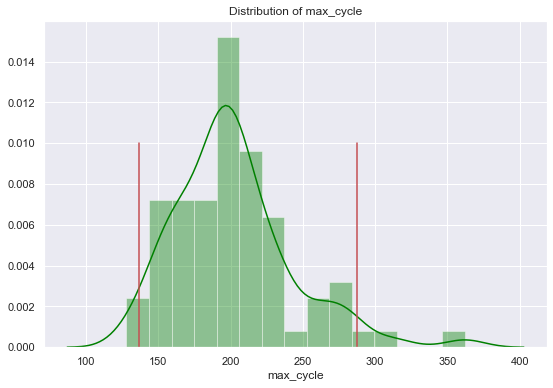

In [10]:
#Select target in [0.025,0.975] interval
y_data = create_df(full_cycles=True)['max_cycle']
y_select = y_data[(y_data.quantile(0.025)<y_data) & (y_data<y_data.quantile(0.975))]
select_index = y_select.index

xleft = y_data.quantile(0.025)
xright = y_data.quantile(0.975)
          
plt.figure(figsize=(9,6))
sns.distplot(y_data, bins=15, color = 'green')
plt.title('Distribution of max_cycle')
plt.plot([xleft,xleft],[0,0.01],'r')
plt.plot([xright,xright],[0,0.01],'r')
plt.show()

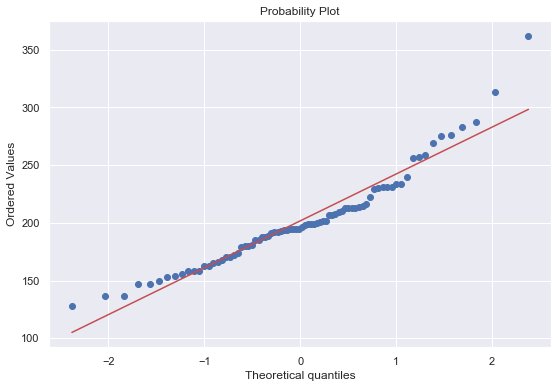

In [11]:
plt.figure(figsize=(9,6))
stats.probplot(y_data, plot=sns.mpl.pyplot)
plt.show()

Данных мало, сложно сказать как распределены значения таргета. От нормального распределения отличается. Критерий Шапиро-Уилка для такой выборки не применим

In [16]:
%%time
scaler = StandardScaler()

selected_scores = []
scores = [] 
for n in [50 + 10*x for x in range(25)]:
    curr_data = create_df(cycles=n)
    
    if 'max_cycle' in curr_data.columns:
        X_data = curr_data.loc[y_select.index].drop(columns='max_cycle')
    else:
        X_data = curr_data.loc[y_select.index]
    
    X_data_scaled = scaler.fit_transform(X_data)
    
    # local feature selection based on Lasso
    lasso = Lasso(random_state=0).fit(X_data_scaled, y_select)
    model = SelectFromModel(lasso, prefit=True)
    X_new = model.transform(X_data_scaled)

    cv_score_selected = cross_val_score(LinearRegression(),
                                        X_new, y_select,
                                        scoring='r2', cv=KFold(n_splits=5,random_state=0)).mean()
    
    cv_score = cross_val_score(LinearRegression(),
                               X_data_scaled, y_select,
                               scoring='r2', cv=KFold(n_splits=5,random_state=0)).mean()
    
    selected_scores.append(cv_score_selected)
    scores.append(cv_score)

Wall time: 1min 1s


Здесь нужно было обучать scaler только на обучающей выборке и трансформировать на всю. Но на r2 это сильно не влияет.

Так же локальный feature selection может вызвать переобучение. Возможное решение - выбор оптимального окна для обучения и отбор признаков на нем. 

Сводим результаты в единую таблицу.

In [17]:
r2_table = pd.DataFrame([selected_scores,scores],
                        index = ['with selection','without'], 
                        columns = ['n_cycls='+str(x) for x in[50 + 10*x for x in range(25)]])

### Результаты

In [14]:
r2_table

,n_cycls=50,n_cycls=60,n_cycls=70,n_cycls=80,n_cycls=90,n_cycls=100,n_cycls=110,n_cycls=120,n_cycls=130,n_cycls=140,...,n_cycls=200,n_cycls=210,n_cycls=220,n_cycls=230,n_cycls=240,n_cycls=250,n_cycls=260,n_cycls=270,n_cycls=280,n_cycls=290
with selection,-5.319326e+25,0.322708,0.702258,0.766539,0.847759,0.837228,0.919532,0.954498,0.967843,0.966403,...,0.992034,0.989867,0.992566,0.991088,0.991055,0.991289,0.990035,0.991012,0.988791,0.990925
without,-6.288140e-01,-0.040429,0.189325,0.445729,0.591264,0.609347,0.762031,0.809010,0.884566,0.903681,...,0.969227,0.953844,0.959742,0.957131,0.952427,0.961593,0.969583,0.970709,0.967096,0.977718


Построим график заисимости R2 от количества использованных циклов для обучения.

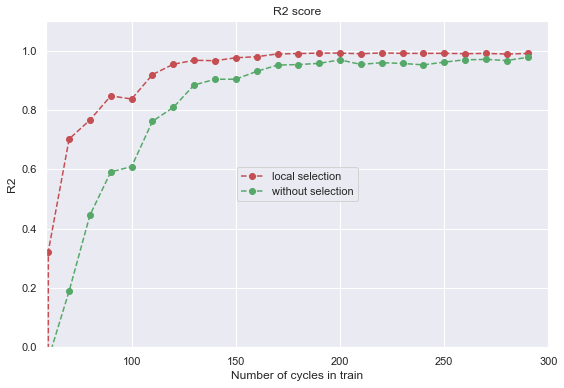

In [15]:
X_plot = [50 + 10*x for x in range(25)]
y_plot_0 = r2_table.iloc[0]
y_plot_1 = r2_table.iloc[1]

plt.figure(figsize=(9,6))
plt.plot(X_plot,y_plot_0,'ro--', label='local selection')
plt.plot(X_plot,y_plot_1,'go--', label='without selection')
plt.xlim(59,300)
plt.ylim(0,1.1)
plt.legend(loc='center')
plt.title('R2 score')
plt.xlabel('Number of cycles in train')
plt.ylabel('R2')
plt.show()

Алгоритм показывает приемлемый скор начиная от числа циклов равных 100. До этого момента продолжительность жизни мотора апроксимируем средним по выборке, с накоплением данных со счетчиков, корректируем прогноз по дате отказа. 

### Пути улучшения
- отбор признаков
- поиск по сетке (grid_search)
- перебор других моделей регресси : lasso, tree, randomforest, tree boosting
- подбор оптимального окна
- добавить признак - текущий цикл работы (чем больше - тем выше вероятность поломки, опасность переобучения)

### Альтернативная постановка

- прогноз вероятности поломки на следующий день, неделю, месяц
- решаем задачу классификации : таргет - поломка в указанный период - 1, продолжает работать - 0
